In [28]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import numpy as np
import pandas as pd

from config.experiment_config import ExperimentConfig

config = ExperimentConfig()

In [30]:
market_data = pd.read_excel(config.PATH_INPUT / config.INPUT_DATA_FILENAME)
market_data = market_data.rename(columns={"Date": "date"})
market_data["date"] = pd.to_datetime(market_data["date"])
market_data = market_data.set_index("date")
market_data.head()

,EMP,PE,CAPE,DY,Rho,MOV,IR,RR,Y02,Y10,...,YSS,NYF,_AU,_DXY,_LCP,_TY,_OIL,_MKT,_VA,_GR
date,,,,,,,,,,,,,,,,,,,,,
1988-04-10,0.022086,12.9,14.469,3.60,-0.083,118.0,6.02,-1.061,7.459,8.484,...,0.248874,6.896895,450.50,89.14,2473.7,97.990,16.88,419.06,823.219,462.551
1988-04-17,0.022086,12.4,13.960,3.75,-0.078,121.0,5.88,-0.760,7.582,8.737,...,0.326712,2.631749,456.25,88.31,2328.2,96.534,18.37,404.66,823.219,462.551
1988-04-24,0.022086,12.4,13.950,3.75,-0.051,123.0,5.83,-0.760,7.618,8.773,...,0.155089,2.631749,449.25,88.89,2201.4,96.470,18.30,404.71,823.219,462.551
1988-05-01,0.021941,12.5,14.036,3.75,-0.054,124.2,5.98,-0.760,7.728,8.873,...,0.145360,2.631749,449.00,89.16,2147.8,96.005,18.00,407.55,840.891,461.176
1988-05-08,0.022104,12.3,13.761,3.82,-0.079,118.4,6.29,-0.760,7.885,8.990,...,0.146644,2.631749,443.00,89.30,2200.9,95.446,17.74,401.29,840.891,461.176


In [31]:
data = market_data.resample("ME").last()

In [32]:
from ipsqt.market_data.risk_free_conventions import accrue_risk_free_rate

FEATURES = ["CAPE", "STP", "M2", "_OIL"]
LOG = ["CAPE"]
LOG_DIFF = ["M2"]
DIFF = ["STP"]

data = data[FEATURES + ["IR", "_MKT"]]
data["MKT_Target"] = data["_MKT"].pct_change()
data["MKT_Return"] = data["_MKT"].pct_change(1)
data["lagged_MKT"] = data["MKT_Target"] # The features are shifted by .shift(1) in the backtester
data["Daily_IR"] = accrue_risk_free_rate(data["IR"] / 100, 365)
data["MKT_Factor"] = data["MKT_Return"] - data["Daily_IR"]

data = data.drop(columns=["_MKT", "IR"])
data[LOG] = np.log(data[LOG]).diff()
data[LOG_DIFF] = np.log(data[LOG_DIFF]).diff()
data[DIFF] = data[DIFF]
data.dropna(axis=0, how="any").to_csv(config.PATH_OUTPUT / config.DF_FILENAME)

/Users/buchkovv/ipsqt/.venv/lib/python3.12/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [33]:
data.dropna(axis=0, how="any")["MKT_Return"].apply(lambda x: 1).to_csv(
    config.PATH_OUTPUT / config.PRESENCE_MATRIX_FILENAME
)

<Axes: xlabel='date'>

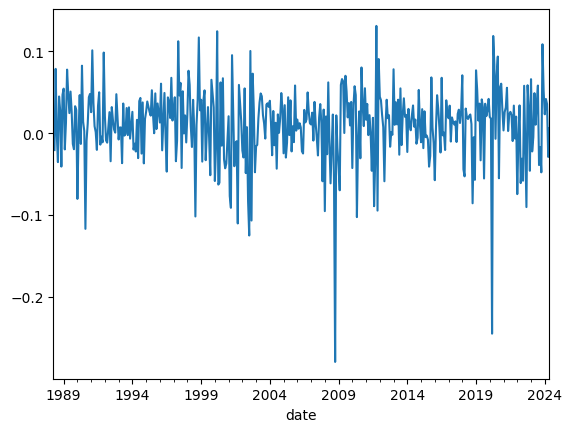

In [34]:
data["MKT_Return"].plot()

In [35]:
data["MKT_Return"].add(1).prod()

np.float64(49.78597020088451)